# TODO

* Analyze duration per image (correlation between duration / arousal valence)
* Normalized audio duration per participant
* Score per 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import sys

from pathlib import Path
import pandas as pd
from scipy.io import wavfile
from IPython.display import display
from functional import seq
import plotly.express as px

sys.path.append("..")
from sgs_utils.path_conf import speech_data_root_dir, loc_data_dir

speech_data_session_dir = speech_data_root_dir.joinpath("backup")
display(speech_data_session_dir)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.plotting.backend = "plotly"


PosixPath('/media/speech_webapp_merged/backup')

## Downloading all the data

In [3]:
# !wget --output-document="speech_data_webapp.zip" https://cloud.ilabt.imec.be/index.php/s/tB2enWmZCJskGmG/download
# !unzip speech_data_webapp.zip
# !mv speech_web_app /project_scratch/data/
# !rm speech_data_webapp.zip


In [4]:
# so we have all folders in backup?
!ls -lh {speech_data_session_dir} | head -n 10

total 0
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:19 2020-11-25__11:08:00+01:00__59b7f538-755a-4bee-8165-158c6795b287
drwxr-xr-x 6 jonas jonas 83 Jun 27 07:19 2020-11-25__11:11:00+01:00__6fb54909-8b1d-4ff5-bc58-912249de7d94
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:19 2020-11-25__11:13:00+01:00__12cd1ed1-17ae-4a4c-8fa8-1363030736e7
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:19 2020-11-25__11:33:00+01:00__9247ce5d-23af-4af4-bb07-6c9b53f8bb90
drwxr-xr-x 4 jonas jonas 54 Jun 27 07:19 2020-11-25__11:35:00+01:00__8c449866-0ac4-4b62-a4a7-d3ce0e7781b6
drwxr-xr-x 3 jonas jonas 39 Jun 27 07:19 2020-11-25__11:45:00+01:00__a03a23eb-ca38-430d-afc6-e47dc4d71f61
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:19 2020-11-25__11:53:00+01:00__8071ebfc-e589-4175-900b-0fadf2627aa5
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:19 2020-11-25__11:54:00+01:00__f752870e-8461-4b7f-bdcc-93649b8caeaa
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:19 2020-11-25__12:15:00+01:00__2f87494b-5d33-46b3-8595-a4da6510ab1f
ls: write error: Broken pipe


In [5]:
# This snippet summarizes the dir-names of the various folders
# within `speech_data_session_dir`
dir_list = []
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue
    dir_list.extend(
        seq(folder.iterdir())
        .filter(lambda x: x.is_dir())
        .map(lambda x: x.name)
        .to_list()
    )
print(pd.Series(dir_list).value_counts())
del dir_list, folder


marloes    104
PiSCES      94
Radboud     88
demo         5
dtype: int64


## 1. Creating the metadata file

The metadata file is constructed of the `.json` file which resides within each user ID 
folder and withholds the person's metadata such as gender, age, education, used mic. etc ...

In [6]:
metadata_dict_list = []

# creating alldata.csv
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue

    metadata = folder.joinpath("metadata.json")
    if not metadata.is_file():
        continue

    with open(metadata, "r") as f:
        metadata_dict = json.load(f)
    metadata_dict["ID"] = folder.name.split("__")[-1]

    metadata_dict["Marloes"] = len(list(folder.joinpath("marloes").glob("*.wav")))
    metadata_dict["PiSCES"] = len(list(folder.joinpath("PiSCES").glob("*.wav")))
    metadata_dict["Radboud"] = len(list(folder.joinpath("Radboud").glob("*.wav")))

    metadata_dict_list.append(metadata_dict)

df_metadata = pd.DataFrame(metadata_dict_list)

# conver the columns to the correct data format
df_metadata["age"] = df_metadata["age"].astype(int)
df_metadata[["sex", "device", "education"]] = df_metadata[
    ["sex", "device", "education"]
].astype("category")
df_metadata["timestamp"] = pd.to_datetime(
    df_metadata.timestamp, utc=True
).dt.tz_convert("Europe/Brussels")

del folder, metadata_dict, metadata_dict_list, f, metadata
df_metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype                          
---  ------          --------------  -----                          
 0   age             201 non-null    int64                          
 1   education       201 non-null    category                       
 2   sex             201 non-null    category                       
 3   timestamp       201 non-null    datetime64[ns, Europe/Brussels]
 4   ID              201 non-null    object                         
 5   Marloes         201 non-null    int64                          
 6   PiSCES          201 non-null    int64                          
 7   Radboud         201 non-null    int64                          
 8   device          128 non-null    category                       
 9   prolific_token  74 non-null     object                         
dtypes: category(3), datetime64[ns, Europe/Brussels](1), int64(4), 

## Analyzing the metadata

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

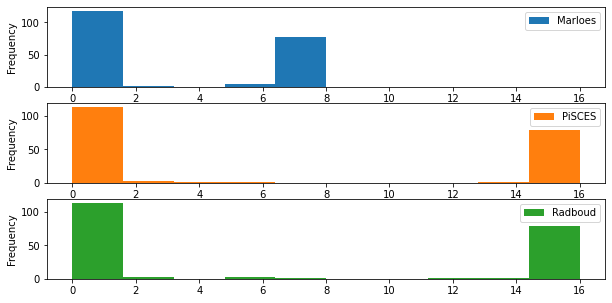

In [7]:
df_metadata[["Marloes", "PiSCES", "Radboud"]].plot(
    subplots=True, kind="hist", figsize=(10, 5), sharex=False, backend="matplotlib"
)


In [8]:
df_metadata_relevant = (
    df_metadata[
        (df_metadata.Marloes >= 6)
        & (df_metadata.Radboud >= 13)
        & (df_metadata.PiSCES >= 13)
    ]
    .reset_index(drop=True)
    .copy()
)

df_metadata_relevant[
    ["age", "sex", "device", "Marloes", "PiSCES", "Radboud"]
].describe()


,age,Marloes,PiSCES,Radboud
count,80.000000,80.00000,80.000000,80.000000
mean,28.775000,6.97500,15.012500,14.987500
std,9.662632,0.15711,0.194465,0.111803
min,19.000000,6.00000,14.000000,14.000000
25%,23.000000,7.00000,15.000000,15.000000
50%,26.000000,7.00000,15.000000,15.000000
75%,31.250000,7.00000,15.000000,15.000000
max,90.000000,7.00000,16.000000,15.000000


male      43
female    37
other      0
Name: sex, dtype: int64

----------------------------------------


pc-mic       34
headset      15
earphones    13
other         5
Name: device, dtype: int64

----------------------------------------


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

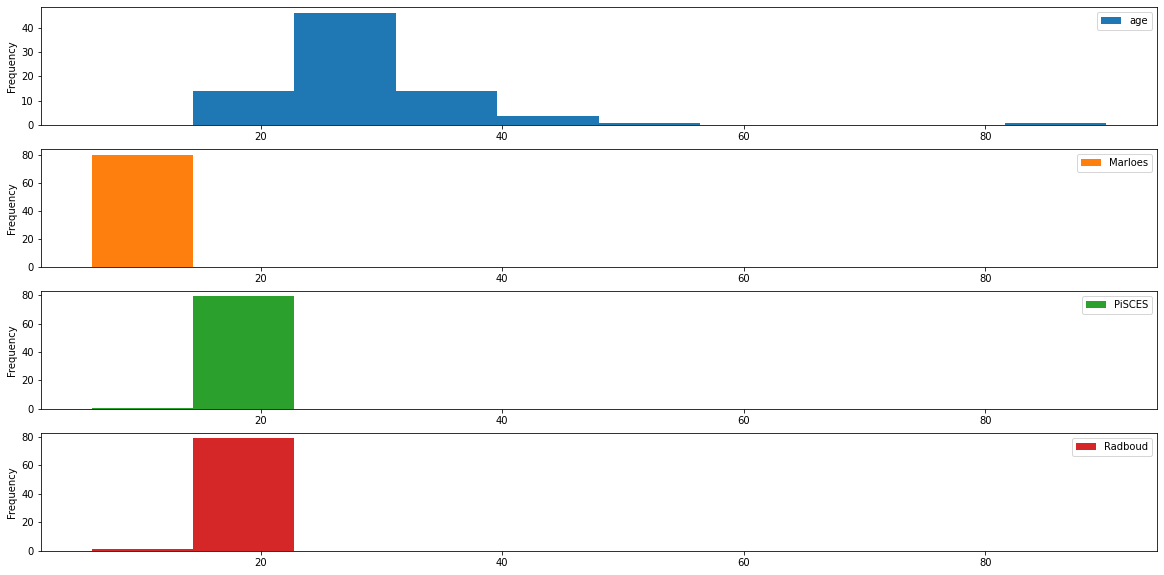

In [9]:
display(df_metadata_relevant.sex.value_counts())
print("-" * 40)
display(df_metadata_relevant.device.value_counts())
print("-" * 40)
df_metadata_relevant.education.value_counts()

# Also plot the distributions
df_metadata_relevant[["age", "device", "Marloes", "PiSCES", "Radboud"]].plot(
    kind="hist", subplots=True, sharex=False, figsize=(20, 10), backend="matplotlib"
)


In [10]:
df_metadata_relevant.to_parquet(loc_data_dir.joinpath("metadata_rel_ids.parquet"))


## Distilling sessions from the relevant metadata

In [11]:
session_dict_list = []

# creating alldata.csv
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue

    def parse_pic_name_ts(db_folder, pic_name, time_str, sep="__") -> dict:
        # what can we save from the wave file?
        # duration - size
        json_f = sep.join([pic_name, time_str]) + ".json"
        json_f = db_folder.joinpath(json_f)
        if not json_f.is_file():
            # print('json_f does not exist')
            return {}

        with open(json_f, "r") as f:
            return json.load(f)

    # TODO -> maybe we can also use the wav duration here as an extra assert.
    def get_wav_json_mapping(db_folder: Path) -> dict:
        # parse the wav files to construct a dataframe
        wav_list = list(db_folder.glob("*.wav"))
        df_db_wav = pd.Series(
            seq(wav_list).map(lambda x: x.name), name="wav_files", dtype="str"
        ).to_frame()
        df_db_wav["wav_time_str"] = df_db_wav["wav_files"].map(
            lambda x: x.split("__")[1].split(".")[0]
        )
        df_db_wav["wav_time_str"] = pd.to_datetime(
            "2022/01/01 " + df_db_wav["wav_time_str"], infer_datetime_format=True
        )
        df_db_wav = df_db_wav.sort_values(by="wav_time_str")

        # parse the json files to construct a datafraem
        json_list = list(db_folder.glob("*.json"))
        df_db_json = pd.Series(
            seq(json_list).map(lambda x: x.name), name="json_files", dtype="str"
        ).to_frame()
        df_db_json["json_time_str"] = df_db_json["json_files"].map(
            lambda x: x.split("__")[1].split(".")[0]
        )
        df_db_json["json_time_str"] = pd.to_datetime(
            "2022/01/01 " + df_db_json["json_time_str"], infer_datetime_format=True
        )
        df_db_json = df_db_json.sort_values(by="json_time_str")

        json_wav_mapping = pd.merge_asof(
            left=df_db_wav,
            right=df_db_json,
            left_on="wav_time_str",
            right_on="json_time_str",
            tolerance=pd.Timedelta(minutes=3),
            # A "forward" search selects the first row in the right DataFrame whose 'on' key
            # is greater than or equal to the left's key.
            direction="forward",
        )

        json_wav_mapping = json_wav_mapping.dropna(how="any", axis=0)
        json_wav_mapping = json_wav_mapping[
            ~(
                json_wav_mapping["wav_time_str"]
                < json_wav_mapping["json_time_str"].shift(1)
            )
        ].reset_index(drop=True)

        assert all(
            (
                json_wav_mapping["json_time_str"].shift(1)
                < json_wav_mapping["wav_time_str"]
            ).values[1:]
        )
        wav_json_mapping_dict = (
            json_wav_mapping[["json_files", "wav_files"]]
            .set_index("wav_files")
            .to_dict()["json_files"]
        )
        return wav_json_mapping_dict

    for db_folder in [folder.joinpath(x) for x in ["marloes", "Radboud", "PiSCES"]]:
        wav_json_mapping_dict = get_wav_json_mapping(db_folder)

        for wav_file in db_folder.glob("*.wav"):
            pic_name, time_str = wav_file.name.split("__")
            metadata_dict = parse_pic_name_ts(db_folder, pic_name, time_str)
            metadata_dict["pic_name"] = pic_name
            metadata_dict["time_str"] = time_str.split(".")[0]
            metadata_dict["wav_size"] = wav_file.stat().st_size
            sample_rate, data = wavfile.read(wav_file)
            metadata_dict["wav_sample_rate"] = sample_rate
            metadata_dict["wav_duration_s"] = round(data.shape[0] / sample_rate, 2)
            ts = pd.Timestamp(wav_file.stat().st_mtime, unit="s", tz="Europe/Amsterdam")
            metadata_dict["wav_timestamp"] = ts + ts.utcoffset()
            metadata_dict["ID"] = db_folder.parent.name.split("__")[-1]
            metadata_dict["DB"] = db_folder.name

            # also read the json file to fetch the arousal and valence values
            if wav_file.name in wav_json_mapping_dict:
                with open(
                    db_folder.joinpath(wav_json_mapping_dict[wav_file.name]), "r"
                ) as f:
                    json_dct = json.load(f)
                    metadata_dict["arousal"] = int(json_dct.get("arousal"))
                    metadata_dict["valence"] = int(json_dct.get("valence"))

            session_dict_list.append(metadata_dict)

df_session = pd.DataFrame(session_dict_list)

# Sanity check - to see whether the wav_time_obj corresponds with the time_str
# there must be < 10 minutes of difference between the two
assert all(
    (
        df_session.apply(
            lambda r: r.wav_timestamp.replace(
                **dict(
                    zip(
                        ["hour", "minute", "second"],
                        list(map(int, r.time_str.split(":"))),
                    )
                )
            ),
            axis=1,
        )
        - df_session.wav_timestamp
    ).abs()
    < pd.Timedelta(minutes=10)
)


del folder, db_folder, wav_file, ts, metadata_dict, session_dict_list, time_str, f
del parse_pic_name_ts, pic_name, wav_json_mapping_dict, json_dct, data, sample_rate

display(df_session.sample(3))

print("-" * 88)

df_session_tot = df_metadata_relevant.merge(
    df_session, how="left", left_on="ID", right_on="ID"
)
display(df_session_tot.sample(3))

del df_session


,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,ID,DB,arousal,valence
2961,Rafd090_01_Caucasian_female_neutral_frontal,21:41:25,8626220,48000,44.93,2022-07-17 21:41:32+02:00,5307991a-b2cd-46b6-a925-3bb998e34da7,Radboud,37.0,78.0
2480,Rafd090_02_Caucasian_female_neutral_frontal,19:04:56,4063276,48000,21.16,2022-06-29 19:05:00+02:00,0e919efd-954e-4c12-98fb-dcf2d0a2b4e0,Radboud,68.0,81.0
671,Picture 93,18:07:05,12451884,44100,70.59,2020-11-30 18:07:14+01:00,3a8266c9-7087-45fe-98e4-6c9c001c0050,PiSCES,59.0,74.0


----------------------------------------------------------------------------------------


,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,prolific_token,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,DB,arousal,valence
1774,20,so,male,2022-06-27 14:25:55.558194+02:00,28d01050-e4e0-4115-a5e9-09c8cb917fb0,7,15,15,pc-mic,60b6567e8882e6423a254d00,marloes,14:36:40,1810476,48000,9.43,2022-06-27 14:36:40+02:00,marloes,31.0,82.0
2362,26,unif,male,2022-06-29 18:46:27.440049+02:00,1bf0c688-1152-4489-8af0-b2419b18f2bf,7,15,15,headset,n.a.,Picture 88,19:15:14,1605676,16000,25.09,2022-06-29 19:15:14+02:00,PiSCES,44.0,68.0
38,20,so,male,2020-11-26 12:40:36.592925+01:00,4949e55b-daff-4255-9741-3206033a736b,7,15,15,NaN,NaN,marloes,13:10:19,2285612,44100,12.96,2020-11-26 13:10:18+01:00,marloes,58.0,58.0


### Add the `DB_no` and `session_no` column

In [ ]:
import numpy as np

test_arr = [1, 10, 3, 5, 2, 8, 100, 12, 200]
print(np.array(test_arr))
print(np.argsort(test_arr))
print(1 + np.argsort(np.argsort(test_arr)))


[  1  10   3   5   2   8 100  12 200]
[0 4 2 3 5 1 7 6 8]
[1 6 3 4 2 5 8 7 9]


In [ ]:
df_session_tot["DB_no"] = df_session_tot.groupby(["ID", "DB"])["wav_timestamp"].apply(
    lambda s: 1 + s.argsort().argsort()
)
df_session_tot["session_no"] = df_session_tot.groupby(["ID"])["wav_timestamp"].apply(
    lambda s: 1 + s.argsort().argsort()
)

df_session_tot["pic_no"] = None
pic_mask = df_session_tot.DB != "marloes"
df_session_tot.loc[pic_mask, "pic_no"] = (
    df_session_tot[pic_mask]
    .groupby(["ID"])
    .wav_timestamp.apply(lambda s: 1 + s.argsort().argsort())
)


## Duration based visualizations

In [ ]:
(
    (df_session_tot.wav_timestamp - df_session_tot.timestamp).dt.total_seconds() / 60
).plot.hist()


In [ ]:
pv = df_session_tot[["DB", "wav_duration_s"]].pivot(
    columns="DB", values="wav_duration_s"
)
pv.sample(10)


DB,PiSCES,Radboud,marloes
2855,NaN,36.22,NaN
1293,NaN,NaN,15.66
2731,24.23,NaN,NaN
822,NaN,36.05,NaN
692,23.81,NaN,NaN
1985,43.39,NaN,NaN
2566,NaN,7.30,NaN
2880,60.89,NaN,NaN
1470,17.15,NaN,NaN
2597,NaN,14.42,NaN


In [ ]:
px.histogram(
    data_frame=df_session_tot,
    x='wav_duration_s',
    color='DB',
    barmode='overlay',
    opacity=0.3,
    nbins=100,
    range_x=[5, 60],
    height=600
)
# px.histogram(
#     df_session_tot[["DB", "wav_duration_s"]].pivot(
#         columns="DB", values="wav_duration_s"
#     ),
#     nbins=100,
#     facet_row="DB",
#     height=800,
#     opacity=0.5,
# )


## Analyzing the sample rate

In [30]:
df_session_tot.wav_sample_rate.value_counts().plot.bar()

### Investigating the file duration

In [19]:
(df_session_tot.wav_duration_s < 5).value_counts()


False    2891
True       67
Name: wav_duration_s, dtype: int64

In [20]:
df_session_tot[(df_session_tot.wav_duration_s < 10)].groupby(
    ["ID", "timestamp", "prolific_token", "DB"]
).size().to_frame()


0
ID                                   timestamp                        prolific_token           DB         
0e919efd-954e-4c12-98fb-dcf2d0a2b4e0 2022-06-29 18:55:57.528852+02:00 5eb9008b8224d385674c39b0 marloes   4
0e92d89e-a869-470f-8318-932da5107b24 2022-06-29 14:43:48.539686+02:00 5be03bf177e0190001b4ad0a PiSCES    2
                                                                                               Radboud   1
1bf0c688-1152-4489-8af0-b2419b18f2bf 2022-06-29 18:46:27.440049+02:00 n.a.                     marloes   1
271093f8-4d3f-4ee0-8a6e-faf9a61c83a4 2022-07-16 12:02:13.631034+02:00 5c5c3370dcea9700016e0bc4 marloes   4
28d01050-e4e0-4115-a5e9-09c8cb917fb0 2022-06-27 14:25:55.558194+02:00 60b6567e8882e6423a254d00 marloes   6
30e98ab0-b9c4-4dfe-a00f-1634bef1c426 2022-06-29 18:40:00.899255+02:00 6106e5fa2185277b70b2dc45 marloes   2
565e07a3-e1b5-49b6-9aa3-8c9dea8fdc5e 2022-06-22 21:15:48.504448+02:00 60b01347f6fc32960811a1d0 marloes   3
795f5119-2b11-49f9-80ea-e5a5ef61f4bf 2022-07-17 13:09:11.536769+02:00 61115e026711eecf59e0e7ee PiSCES    1
87eafb16-0598-4340-9564-8e630acf85d6 2022-07-16 13:40:19.209381+02:00 5da367636f69c500149e6216 PiSCES   12
                                                                                               Radboud  13
9bd9b20c-97aa-4435-a704-149d55c4403a 2022-06-22 21:13:05.634330+02:00 5efe473e63271c33b8744de3 Radboud   4
                                                                                               marloes   1
a1b0f7d5-eb44-4d1a-85ec-02578d5dc2ae 2022-06-27 16:45:11.613628+02:00 n.a.                     marloes   2
a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f 2022-06-27 22:18:01.896264+02:00 5f2be3f5d81eaf0009520f8b PiSCES   14
                                                                                               Radboud  15
                                                                                               marloes   6
aeacc3a4-754e-4cd3-9ce7-62a41147d637 2022-07-17 13:12:59.023908+02:00 5eff53e20c71ad0ddef4afe7 marloes   5
b175704a-f30d-4143-a3b5-5cbd779b7859 2022-06-27 23:15:37.075319+02:00 610d81f2bff565abfe63ddf0 marloes   4
b4e53aa5-3bdc-4451-9cbf-20e94668f86c 2022-07-17 14:17:17.399922+02:00 n.a.                     marloes   2
c0f5c29a-86ed-4a03-bbae-6794c5410b9e 2022-06-27 14:21:19.557038+02:00 60fda9f63988e51f773e1301 marloes   3
c30db4c2-a62a-4d69-8f1b-893a1f4b8c9d 2022-07-16 21:49:33.730743+02:00 5e360d610d43625c7da0a09d Radboud   1
c6a3fb30-04d8-470a-907b-6b81cfcdce83 2022-07-16 16:56:27.840661+02:00 n.a.                     marloes   1
e61cd702-cd5f-4258-b4ef-57665e20803c 2022-06-29 14:23:23.366587+02:00 5b0c1fdebd9c3100015641ae PiSCES    1

### Filtering events

In [21]:
df_session_tot.shape


(2958, 22)

In [22]:
df_session_tot.sample(3)


,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,prolific_token,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,DB,arousal,valence,DB_no,session_no,pic_no
2030,28,ho,female,2022-06-27 22:01:48.323990+02:00,0c28e160-d7bb-4b17-829c-c9ebc7ad0a1f,7,15,15,pc-mic,60fdb9bad55eb8c5b67f18f4,Picture 93,22:48:23,6766636,48000,35.24,2022-06-27 22:48:24+02:00,PiSCES,34.0,89.0,14,33,27
2845,19,so,male,2022-07-17 14:17:17.399922+02:00,b4e53aa5-3bdc-4451-9cbf-20e94668f86c,7,15,15,pc-mic,n.a.,Picture 96,14:45:22,3883052,44100,22.01,2022-07-17 14:44:58+02:00,PiSCES,86.0,55.0,9,21,17
142,21,so,female,2020-11-26 16:20:57.753838+01:00,b8b6a8ee-2b45-41e1-9d93-3eacbc25fc34,7,14,14,NaN,NaN,Picture 87,16:58:24,8609836,48000,44.84,2020-11-26 16:58:26+01:00,PiSCES,63.0,59.0,9,21,17


In [23]:
# We store the pic_count (number of times the user described the picutre) to use a a future filter
df_session_tot["pic_count"] = (
    df_session_tot[df_session_tot.DB != "marloes"]
    .groupby(["ID", "pic_name"])["pic_name"]
    .transform("count")
)

out = df_session_tot[df_session_tot.DB != "marloes"].groupby(["ID", "pic_name"]).size()
display(out[out > 1])
del out


ID                                    pic_name                                   
716dc108-5588-49ed-bf3c-04fb87212e2b  Picture 59                                     2
9223720f-1a2a-4811-84a1-a421646f63a0  Picture 59                                     2
e0c00b33-2151-4bcf-98b8-82f7701fccea  Picture 81                                     2
                                      Rafd090_32_Caucasian_female_neutral_frontal    2
dtype: int64

In [24]:
ids_to_skip = [
    "a97a84b6-7a66-461f-810e-b54bac686f64",  # Test run mitchel (a lot of short sessions)
    "a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f",  # Too much short sessions
    "87eafb16-0598-4340-9564-8e630acf85d6",  # This prolific users does not want to be included into the data analysis
    # TODO -> we do not need to throw thes all away; but for sake of simplicity we do now
    # "716dc108-5588-49ed-bf3c-04fb87212e2b",  # Got Picture 59 twice
    # "9223720f-1a2a-4811-84a1-a421646f63a0",  # Got Picture 59 twice
    # "e0c00b33-2151-4bcf-98b8-82f7701fccea",  # Got Picture 81 and Rafd090_32_Caucasian_female_neutral_frontal twice
]

df_session_tot_cleaned = df_session_tot[
    (~df_session_tot.ID.isin(ids_to_skip)) & (df_session_tot.wav_size > 100)
].copy()
df_session_tot_cleaned = df_session_tot_cleaned.sort_values(
    by=["ID", "wav_timestamp"], ignore_index=True
)
display(df_session_tot_cleaned.shape)


(2826, 23)

In [25]:
# custom parsing
display(
    df_session_tot_cleaned[
        df_session_tot_cleaned.ID == "f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34"
    ]
    .sort_values(by="wav_timestamp")[["session_no", "wav_timestamp", "DB"]]
    .iloc[:10]
)
# this user starts with pisces and has a total of 6 marloes instead of 7
# for some reason, the first marloes was not stored -> adjust the session_no and DB_no
df_session_tot_cleaned.loc[
    df_session_tot_cleaned.ID == "f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34", "session_no"
] += 1
df_session_tot_cleaned.loc[
    (df_session_tot_cleaned.ID == ("f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34"))
    & (df_session_tot_cleaned.DB == "marloes"),
    "DB_no",
] += 1
display(
    df_session_tot_cleaned[
        df_session_tot_cleaned.ID == "f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34"
    ]
    .sort_values(by="wav_timestamp")[["session_no", "wav_timestamp", "DB"]]
    .iloc[:10]
)


,session_no,wav_timestamp,DB
2716,1,2020-12-01 17:29:06+01:00,PiSCES
2717,2,2020-12-01 17:29:42+01:00,Radboud
2718,3,2020-12-01 17:30:44+01:00,PiSCES
2719,4,2020-12-01 17:31:22+01:00,Radboud
2720,5,2020-12-01 17:32:34+01:00,PiSCES
2721,6,2020-12-01 17:33:10+01:00,marloes
2722,7,2020-12-01 17:33:52+01:00,Radboud
2723,8,2020-12-01 17:34:44+01:00,PiSCES
2724,9,2020-12-01 17:36:02+01:00,Radboud
2725,10,2020-12-01 17:36:40+01:00,PiSCES


,session_no,wav_timestamp,DB
2716,2,2020-12-01 17:29:06+01:00,PiSCES
2717,3,2020-12-01 17:29:42+01:00,Radboud
2718,4,2020-12-01 17:30:44+01:00,PiSCES
2719,5,2020-12-01 17:31:22+01:00,Radboud
2720,6,2020-12-01 17:32:34+01:00,PiSCES
2721,7,2020-12-01 17:33:10+01:00,marloes
2722,8,2020-12-01 17:33:52+01:00,Radboud
2723,9,2020-12-01 17:34:44+01:00,PiSCES
2724,10,2020-12-01 17:36:02+01:00,Radboud
2725,11,2020-12-01 17:36:40+01:00,PiSCES


In [26]:
df_session_tot_cleaned[
    (df_session_tot_cleaned.wav_duration_s < 10)
    & (df_session_tot_cleaned.DB != "marloes")
].groupby(["ID", "timestamp", "DB"]).size().to_frame()


0
ID                                   timestamp                        DB         
0bae55f8-2aab-4c7b-917f-7f0c3e627e5f 2020-11-27 20:02:22.592132+01:00 Radboud   3
29fb88a7-d9de-428b-9905-88d1f05a6154 2020-12-09 15:55:02.026184+01:00 PiSCES    1
                                                                      Radboud   8
3bdd33ef-9671-4a3e-b152-eff41ef674e8 2020-12-01 10:39:34.523391+01:00 Radboud   1
5ef38e39-8146-4cf5-b365-43a08eac9905 2020-11-29 16:26:03.291969+01:00 PiSCES    5
                                                                      Radboud  11
716dc108-5588-49ed-bf3c-04fb87212e2b 2020-11-27 12:06:42.365579+01:00 PiSCES    1
7e62dc42-e811-4674-ba8b-302850dd84e5 2020-11-30 13:47:57.876901+01:00 PiSCES    1
c30db4c2-a62a-4d69-8f1b-893a1f4b8c9d 2022-07-16 21:49:33.730743+02:00 Radboud   1
e61cd702-cd5f-4258-b4ef-57665e20803c 2022-06-29 14:23:23.366587+02:00 PiSCES    1

In [27]:
df_session_tot_cleaned.to_parquet(
    loc_data_dir.joinpath("df_session_tot_cleaned.parquet")
)

df_session_tot.to_parquet(
    loc_data_dir.joinpath("df_session_tot.parquet")
)